In [1]:
import pickle 
import pandas as pd 
from typing import NamedTuple
from tqdm import tqdm 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm

In [2]:
class DatasetArgs(NamedTuple): 
    name: str 
    train_path: str 
    test_path: str
scratch_path = '/home/mila/r/rebecca.salganik/scratch/MusicSAGE_Data_Final2/'      
datasets = {
    'LFM': DatasetArgs(name='LFM', train_path=scratch_path + 'LFM_Subset/train_val.pkl', test_path = scratch_path + 'LFM_Subset/test.pkl'), 
    'MPD': DatasetArgs(name='MPD', train_path=scratch_path + 'MPD_Subset/train_val.pkl', test_path = scratch_path + 'test.pkl'),    }

colors = {'LFM': '#FF5733' , 
         'MPD':'#AF33FF'}

# User Preference

In [7]:

    
def user_pref(dataset):
    data = pickle.load(open(datasets[dataset].train_path, "rb"))
    tracks = data['df_track'][['tid','appear_raw', 'log10_popcat', '80_20_LT']]
    interact = data['df_playlist']
    interact_with_pop = pd.merge(interact, tracks).sort_values('pid').astype({'log10_popcat': int})
    LT_counts = pd.get_dummies(interact_with_pop[['pid', 'log10_popcat','80_20_LT']], 
               columns=['log10_popcat','80_20_LT']).groupby(['pid'], as_index=False).mean()
    LT_80_20_col = ['pid'] + [c for c in LT_counts.columns if '80_20' in c] 
    LT_10bin_col = ['pid'] + [c for c in LT_counts.columns if '10' in c] 
    
    
    avg_pref_80_20 = LT_counts[LT_80_20_col].mean()
    avg_pref_10bin = LT_counts[LT_10bin_col].mean()
    
    return LT_counts[LT_80_20_col], LT_counts[LT_10bin_col], avg_pref_80_20, avg_pref_10bin

def plot_pref(details, summary, name, dataset): 
    
    
    mpl.rcParams['font.size'] = 22
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Tahoma']
    
    LT_col = [c for c in details.columns if name in c]
    plt.bar(list(range(len(LT_col))), summary[LT_col].values, color='#FF5733')
    plt.xticks(list(range(len(LT_col))), ) 

    plt.xlabel("popularity bin")
    plt.ylabel("avg user preference")
    plt.title(f"{dataset}", fontsize=25, fontname="Times New Roman", fontweight="bold")
    plt.show()



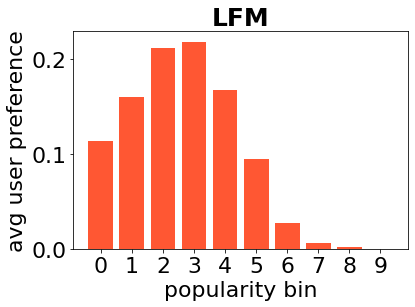

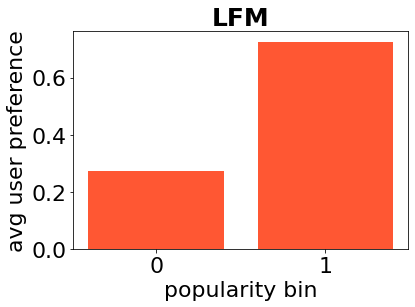

In [8]:
details_80_20, details_10bin, summary_80_20, summary_10bin = user_pref('LFM')
plot_pref(details_10bin,summary_10bin, '10', 'LFM' )
plot_pref(details_80_20,summary_80_20, 'LT', 'LFM' )

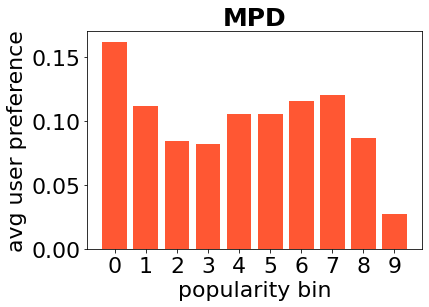

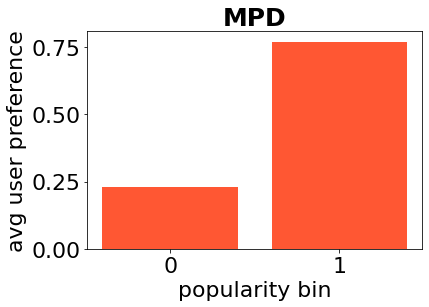

In [9]:
details_80_20, details_10bin, summary_80_20, summary_10bin = user_pref('MPD')
plot_pref(details_10bin,summary_10bin, '10', 'MPD')
plot_pref(details_80_20,summary_80_20, 'LT', 'MPD' )

# Binning Plots 

In [6]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])


def binning_plots(dataset):
    data = pickle.load(open(datasets[dataset].train_path, "rb"))
    tracks = data['df_track'][['tid','appear_raw', 'log10_popcat', '80_20_LT']].sort_values('appear_raw', ascending=False)
    interact = data['df_playlist']
    interact_with_pop = pd.merge(interact, tracks) #.sort_values('pid').astype({'log10_popcat': int})

    bin10_nums = []
    bin80_20_nums = [] 
    bin10_borders = []
    bin80_20_borders = []


    grp = tracks[tracks.log10_popcat == 0]
    num_tracks = len(grp)
    grp_max = max(grp.tid)
    grp_max, num_tracks


    for i in range(10):
        grp = tracks[tracks.log10_popcat == i]
        num_tracks = len(grp)
        bin10_nums.append(num_tracks)
        grp_max = max(grp.tid)
        bin10_borders.extend([grp_max])

    for i in range(2): 

        grp = tracks[tracks['80_20_LT'] == i]
        num_tracks = len(grp)
        bin80_20_nums.append(num_tracks)
        bin80_20_borders.extend([grp_max])
    
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Tahoma']
    
    fig, ax = plt.subplots()
    ax.bar(list(range(10)) , bin10_nums, color='#FF5733') 
    ax.set_xticks(list(range(10))) # the default tick labels will be these same numbers
    ax.set_xlabel("Bin Category")
    ax.set_ylabel("Number of Tracks")
    plt.title(f'{dataset}', fontsize=25)
    plt.yscale('log')
    plt.show()

    # tracks_sorted = tracks.sort_values('appear_raw', ascending=False)
    fig, ax = plt.subplots()
    ax.plot(range(0, len(tracks)), tracks.appear_raw)  
#     ax.set_xticks(bin10_nums)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Popularity")
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'{dataset}', fontsize=25, weight = 'bold')
    d = np.zeros(len(tracks))

    ax.fill_between(range(len(tracks)), tracks.appear_raw, where=tracks.appear_raw>=d, color='cyan')
    ax.vlines(x=sorted(bin10_nums), ymin=0, ymax = max(tracks.appear_raw), colors='purple', ls='--', lw=2, label='log10')
    ax.vlines(x=sorted(bin80_20_nums), ymin=0, ymax = max(tracks.appear_raw), colors='red', ls='--', lw=2, label = '20/80 LT')
    plt.legend(fontsize=15)
    plt.show() 



    fig, ax = plt.subplots()
    ax.plot(range(0, len(tracks)), tracks.appear_raw)
#     labels = np.arange(0, len(tracks),10000)
    labels = [t for t in ax.get_xticks().tolist() if t > 0]
#     labels = ['0'] + [str(t).replace('000', '') + 'K' for t in labels]
    
#     labels = ['0'] + [f"{t:}K"]
    labels = ['0'] + [human_format(t) for t in labels]
    print(labels)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Popularity")
    # plt.yscale('log')
    # plt.xscale('log')
    plt.title(f'{dataset}', fontsize=25, weight = 'bold')
    d = np.zeros(len(tracks))

    ax.fill_between(range(len(tracks)), tracks.appear_raw, where=tracks.appear_raw>=d, color='cyan')
    ax.vlines(x=sorted(bin10_nums), ymin=0, ymax = max(tracks.appear_raw), colors='purple', ls='--', lw=2, label='log10')
    ax.vlines(x=sorted(bin80_20_nums), ymin=0, ymax = max(tracks.appear_raw), colors='red', ls='--', lw=2, label = '20/80 LT')
    plt.legend()
    plt.show() 

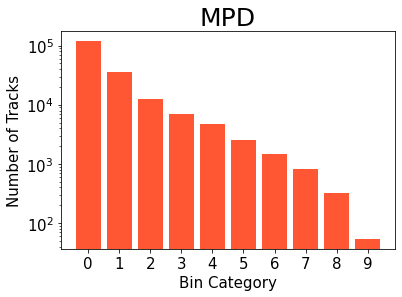

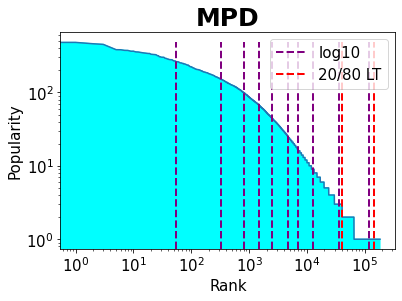

['0', '50K', '100K', '150K', '200K']


/tmp/ipykernel_19130/3239388431.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


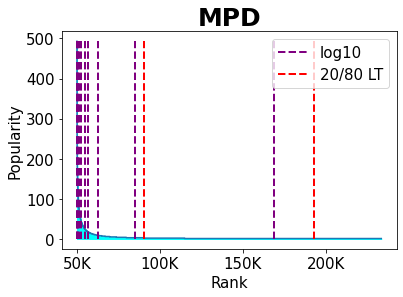

In [7]:
binning_plots('MPD')

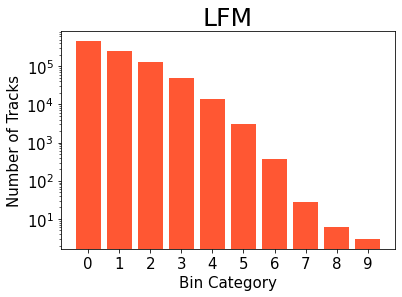

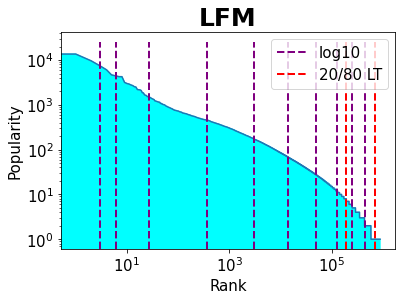

['0', '200K', '400K', '600K', '800K', '1M']


/tmp/ipykernel_19130/3239388431.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


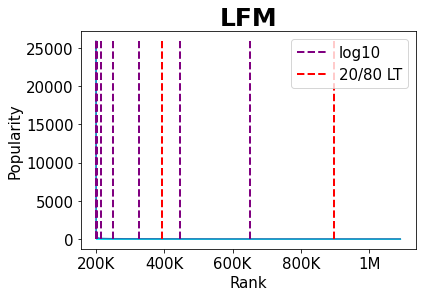

In [8]:
binning_plots('LFM')

In [24]:


number = 1000_000
print(human_format(number))

1M


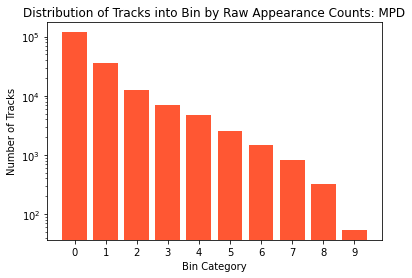

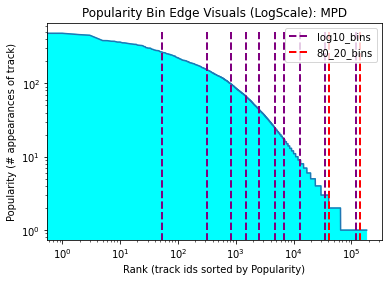

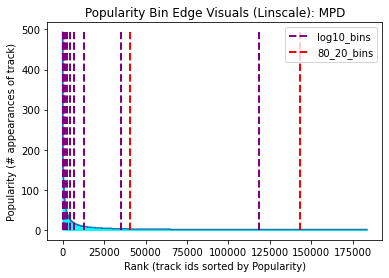

In [53]:
###TESTING 


dataset = 'MPD'
data = pickle.load(open(datasets['MPD'].train_path, "rb"))
tracks = data['df_track'][['tid','appear_raw', 'log10_popcat', '80_20_LT']].sort_values('appear_raw', ascending=False)
interact = data['df_playlist']
interact_with_pop = pd.merge(interact, tracks) #.sort_values('pid').astype({'log10_popcat': int})

bin10_nums = []
bin80_20_nums = [] 
bin10_borders = []
bin80_20_borders = []


grp = tracks[tracks.log10_popcat == 0]
num_tracks = len(grp)
grp_max = max(grp.tid)
grp_max, num_tracks


for i in range(10):
    grp = tracks[tracks.log10_popcat == i]
    num_tracks = len(grp)
    bin10_nums.append(num_tracks)
    grp_max = max(grp.tid)
    bin10_borders.extend([grp_max])

for i in range(2): 

    grp = tracks[tracks['80_20_LT'] == i]
    num_tracks = len(grp)
    bin80_20_nums.append(num_tracks)
    bin80_20_borders.extend([grp_max])
    
fig, ax = plt.subplots()
ax.bar(list(range(10)) , bin10_nums, color='#FF5733') 
ax.set_xticks(list(range(10))) # the default tick labels will be these same numbers
ax.set_xlabel("Bin Category")
ax.set_ylabel("Number of Tracks")
plt.title(f'Distribution of Tracks into Bin by Raw Appearance Counts: {dataset}')
plt.yscale('log')
plt.show()

# tracks_sorted = tracks.sort_values('appear_raw', ascending=False)
fig, ax = plt.subplots()
ax.plot(range(0, len(tracks)), tracks.appear_raw)  
ax.set_xticks(bin10_nums)
ax.set_xlabel("Rank (track ids sorted by Popularity)")
ax.set_ylabel("Popularity (# appearances of track)")
plt.yscale('log')
plt.xscale('log')
plt.title(f'Popularity Bin Edge Visuals (LogScale): {dataset}')
d = np.zeros(len(tracks))

ax.fill_between(range(len(tracks)), tracks.appear_raw, where=tracks.appear_raw>=d, color='cyan')
ax.vlines(x=sorted(bin10_nums), ymin=0, ymax = max(tracks.appear_raw), colors='purple', ls='--', lw=2, label='log10_bins')
ax.vlines(x=sorted(bin80_20_nums), ymin=0, ymax = max(tracks.appear_raw), colors='red', ls='--', lw=2, label = '80_20_bins')
plt.legend()
plt.show() 



fig, ax = plt.subplots()
ax.plot(range(0, len(tracks)), tracks.appear_raw)  
# ax.set_xticks(bin10_nums)
ax.set_xlabel("Rank (track ids sorted by Popularity)")
ax.set_ylabel("Popularity (# appearances of track)")
# plt.yscale('log')
# plt.xscale('log')
plt.title(f'Popularity Bin Edge Visuals (Linscale): {dataset}')
d = np.zeros(len(tracks))

ax.fill_between(range(len(tracks)), tracks.appear_raw, where=tracks.appear_raw>=d, color='cyan')
ax.vlines(x=sorted(bin10_nums), ymin=0, ymax = max(tracks.appear_raw), colors='purple', ls='--', lw=2, label='log10_bins')
ax.vlines(x=sorted(bin80_20_nums), ymin=0, ymax = max(tracks.appear_raw), colors='red', ls='--', lw=2, label = '80_20_bins')
plt.legend()
plt.show() 

# OLDDDDD

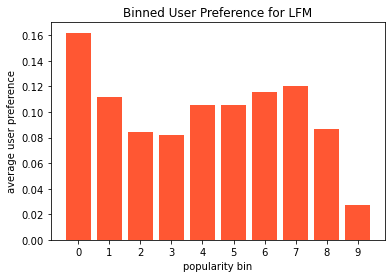

In [125]:
LT_col = [c for c in details_10bin.columns if '10' in c ]

plt.bar(list(range(10)), summary_10bin[LT_col].values, color='#FF5733')
plt.xticks(list(range(10)))
plt.xlabel("popularity bin")
plt.ylabel("average user preference")
plt.title("Binned User Preference for LFM")
plt.show()

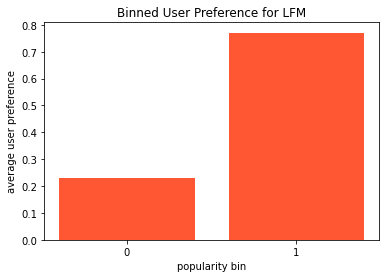

In [127]:
LT_col = [c for c in details_80_20.columns if 'LT' in c ]

plt.bar(list(range(2)), summary_80_20[LT_col].values, color='#FF5733')
plt.xticks(list(range(2)))
plt.xlabel("popularity bin")
plt.ylabel("average user preference")
plt.title("Binned User Preference for LFM")
plt.show()

# OLD 

In [26]:
data = pickle.load(open(datasets['MPD'].train_path, "rb"))
tracks = data['df_track'][['tid','appear_raw', 'log10_popcat', '80_20_LT']]
interact = data['df_playlist']
interact_with_pop = pd.merge(interact, tracks).sort_values('pid').astype({'log10_popcat': int})

In [86]:
data['df_track'].columns

Index(['track_uri', 'track_name', 'arid', 'artist_uri', 'alid', 'album_uri',
       'followers', 'popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'img_emb', 'track_name_emb', 'genre',
       'followers_10cat', 'popularity_10cat', 'tid', 'appear_raw', 'vis',
       'appear_pop', 'log10_popcat', '80_20_LT'],
      dtype='object')

In [27]:
interact_with_pop

,pos,tid,pid,appear_raw,log10_popcat,80_20_LT
171620,133,1009,0,278,9,1
335069,56,2081,0,53,6,1
334949,218,527,0,22,4,1
164751,75,11529,0,23,5,1
246276,153,7642,0,36,5,1
...,...,...,...,...,...,...
401625,80,173290,10999,1,0,0
401626,81,173291,10999,1,0,0
401556,11,173221,10999,1,0,0
401651,106,173316,10999,1,0,0


In [82]:
# interact_with_pop.groupby('pid')[['tid', 'log10_popcat', '80_20_LT']]

print(len(interact_with_pop[(interact_with_pop.pid == 0) & (interact_with_pop.log10_popcat == 0)]), 
len(interact_with_pop[(interact_with_pop.pid == 0) ]), 6/228)

6 228 0.02631578947368421


In [84]:
LT_counts = pd.get_dummies(interact_with_pop[['pid', 'log10_popcat','80_20_LT']], 
               columns=['log10_popcat','80_20_LT']).groupby(['pid'], as_index=False).mean()
LT_counts

,pid,log10_popcat_0,log10_popcat_1,log10_popcat_2,log10_popcat_3,log10_popcat_4,log10_popcat_5,log10_popcat_6,log10_popcat_7,log10_popcat_8,log10_popcat_9,80_20_LT_0,80_20_LT_1
0,0,0.026316,0.083333,0.074561,0.039474,0.135965,0.184211,0.149123,0.162281,0.127193,0.017544,0.087719,0.912281
1,1,0.000000,0.004785,0.009569,0.004785,0.057416,0.071770,0.263158,0.358852,0.220096,0.009569,0.000000,1.000000
2,2,0.000000,0.041667,0.000000,0.041667,0.041667,0.000000,0.166667,0.458333,0.208333,0.041667,0.041667,0.958333
3,3,0.232558,0.069767,0.069767,0.046512,0.186047,0.093023,0.093023,0.162791,0.046512,0.000000,0.255814,0.744186
4,4,0.014493,0.014493,0.057971,0.000000,0.043478,0.130435,0.188406,0.246377,0.188406,0.115942,0.028986,0.971014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,10995,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
10996,10996,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
10997,10997,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
10998,10998,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [67]:
tid_counts = interact_with_pop.groupby('pid')['tid'].apply(len).reset_index(name='num_tids')


In [72]:
LT_pref = pd.merge(tid_counts, LT_counts, on="pid")

In [73]:
LT_pref.columns

Index(['pid', 'num_tids', 'log10_popcat_0', 'log10_popcat_1', 'log10_popcat_2',
       'log10_popcat_3', 'log10_popcat_4', 'log10_popcat_5', 'log10_popcat_6',
       'log10_popcat_7', 'log10_popcat_8', 'log10_popcat_9', '80_20_LT_0',
       '80_20_LT_1'],
      dtype='object')

In [74]:
LT_cols = [c for c in LT_pref.columns if 'pid' not in c and 'tid' not in c]


In [3]:
def get_user_pref(gt_with_pop_info, LT_col): 
    data = []   
    for pid in tqdm(gt_with_pop_info.pid.unique()): 
        track_set = gt_with_pop_info[gt_with_pop_info.pid == pid]
        LT = len(track_set[track_set[LT_col] == 0])/gen_amount 
        nLT = len(track_set[track_set[LT_col] > 0])/gen_amount 
        data.append([pid, LT, nLT]) 
    user_pref_df = pd.DataFrame(data = data, columns = ['pid', 'LT', 'ST'])
    return user_pref_df

In [12]:
def user_pref(dataset): 
    data = pickle.load(open(datasets[dataset].train_path, "rb"))
    if 'Filtered' in dataset: 
        tracks = data['df_track'][['tid', 'appear_raw', '80_20_LT']]
        
    elif 'LFM' in dataset: 
        tracks = data['df_track'][['tid', 'appear_raw', '80_20_LT', 'log10_popcat']]
    else: 
        tracks = data['df_track'][['tid', 'appear_raw', 'log10_popcat']]
    interact = data['df_playlist']
    interact_with_pop = pd.merge(interact, tracks)
    
    if 'MPD' in dataset: 
        user_pref_log10 = get_user_pref(interact_with_pop, LT_col='log10_popcat')

        print("log10 details: \n average LT:{}, average ST:{}".format( 
                np.mean(user_pref_log10['LT']), np.mean(user_pref_log10['ST'])))
        return user_pref_log10, None
    
    elif 'Filtered' in dataset: 
        user_pref_80_20 = get_user_pref(interact_with_pop, LT_col='80_20_LT')
        print("80/20 details: \n average LT:{}, average ST:{}".format(
                np.mean(user_pref_80_20['LT']), np.mean(user_pref_80_20['ST']))) 
        return None, user_pref_80_20
    
    else:
        user_pref_80_20 = get_user_pref(interact_with_pop, LT_col='80_20_LT')
        user_pref_log10 = get_user_pref(interact_with_pop, LT_col='log10_popcat')

        print("80/20 details: \n average LT:{}, average ST:{} \n log10 details: \n average LT:{}, average ST:{}".format( 
            np.mean(user_pref_80_20['LT']), np.mean(user_pref_80_20['ST']),    
            np.mean(user_pref_log10['LT']), np.mean(user_pref_log10['ST'])))
        return user_pref_log10, user_pref_80_20
        

In [ ]:
user_pref('LFM_Filtered')

In [15]:
user_pref('MPD')

100%|████████████████████████████████████████████████████| 11000/11000 [00:13<00:00, 811.03it/s]


log10 details: 
 average LT:0.07581953867028493, average ST:0.5982157394843962


In [17]:
user_pref('LFM')

100%|████████████████████████████████████████████████████| 10167/10167 [01:23<00:00, 121.04it/s]


log10 details: 
 average LT:0.012321731987401746, average ST:0.1370950788713445


In [13]:
log10, split_80_20 = user_pref('LFM')

100%|████████████████████████████████████████████████████| 10167/10167 [01:24<00:00, 120.00it/s]


80/20 details: 
 average LT:0.034496748654595524, average ST:0.11492006220415074 
 log10 details: 
 average LT:0.012321731987401746, average ST:0.1370950788713445


# Plotting 

In [20]:
LFM = pickle.load(open(datasets['LFM'].train_path, "rb"))['df_track'][['tid', 'appear_raw', '80_20_LT', 'log10_popcat']]



#'/home/mila/r/rebecca.salganik/scratch/MusicSAGE_data_final/LFM_Subset/Smaller_Size/train_val_data8.pkl'

In [21]:
nums = []
borders = []

for i in range(10):
    grp = LFM[LFM.log10_popcat == i]
    num_tracks = len(grp)
    nums.append(num_tracks)
    grp_min, grp_max = min(grp.appear_raw), max(grp.appear_raw)
    
    borders.extend([grp_max])
    print(i,num_tracks, grp_min, grp_max)
    
borders


# old_borders = [0 450230 1 2
# 1 246159 3 7
# 2 127044 8 21
# 3 49531 22 58
# 4 14110 59 160
# 5 3094 161 444
# 6 364 445 1220
# 7 27 1235 3168
# 8 6 4252 7378
# 9 3 9608 25885]

0 450230 1 2
1 246159 3 7
2 127044 8 21
3 49531 22 58
4 14110 59 160
5 3094 161 444
6 364 445 1220
7 27 1235 3168
8 6 4252 7378
9 3 9608 25885


[2, 7, 21, 58, 160, 444, 1220, 3168, 7378, 25885]

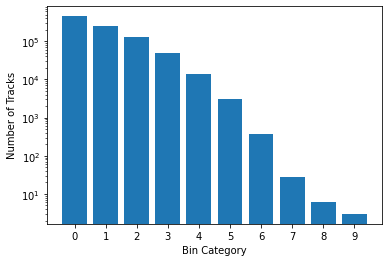

In [22]:
fig, ax = plt.subplots()
ax.bar(list(range(10)) , nums) 
ax.set_xticks(list(range(10))) # the default tick labels will be these same numbers
ax.set_xlabel("Bin Category")
ax.set_ylabel("Number of Tracks")
plt.yscale('log')
plt.show()

In [62]:
counts = []
borders = []
 
for i in range(2):
    grp = LFM[LFM['80_20_LT'] == i]
    num_tracks = len(grp)
    counts.append(num_tracks)
    grp_min, grp_max = min(grp.appear_raw), max(grp.appear_raw)
    
#     borders.extend([grp_min, grp_max])
    print(i,num_tracks, grp_min, grp_max)
    
counts

0 696389 1 7
1 194179 8 25885


[696389, 194179]

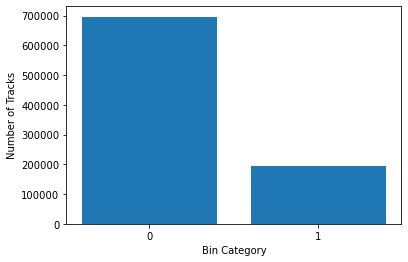

In [66]:
fig, ax = plt.subplots()
ax.bar(list(range(2)), counts) 
ax.set_xticks(list(range(2))) # the default tick labels will be these same numbers
ax.set_xlabel("Bin Category")
ax.set_ylabel("Number of Tracks")

plt.show()

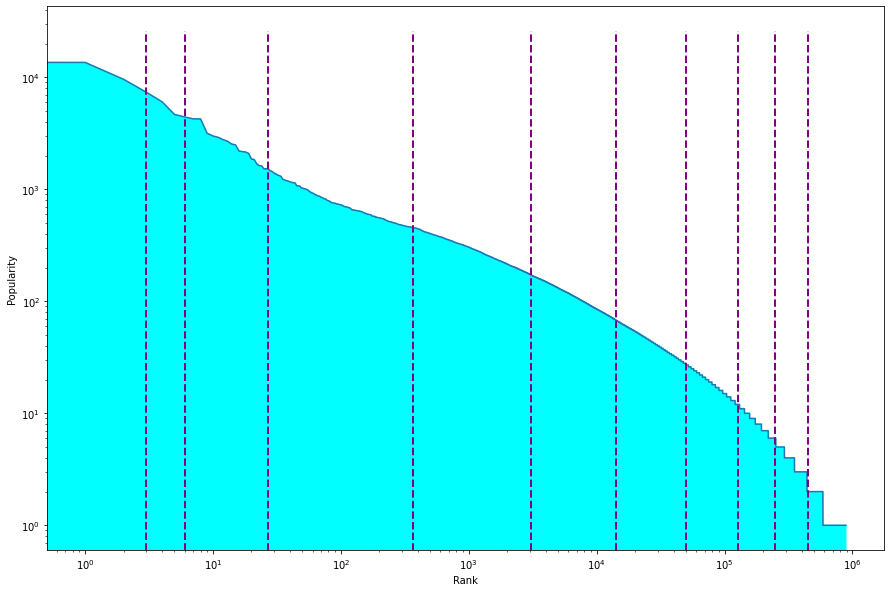

In [134]:
LFM_sorted = LFM.sort_values('appear_raw', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(range(0, len(LFM_sorted)), LFM_sorted.appear_raw)  
# ax.set_xticks(range(0, len(LFM_sorted), 100000)) # the default tick labels will be these same numbers
ax.set_xticks(nums)
ax.set_xlabel("Rank")
ax.set_ylabel("Popularity")
plt.yscale('log')
plt.xscale('log')
d = np.zeros(len(LFM_sorted))
ax.fill_between(range(len(LFM_sorted)), LFM_sorted.appear_raw, where=LFM_sorted.appear_raw>=d, color='cyan')
ax.vlines(x=sorted(nums), ymin=0, ymax = max(LFM_sorted.appear_raw), colors='purple', ls='--', lw=2)
# plt.show()

In [121]:
sorted(nums) , len(nums)

([3, 6, 27, 364, 3094, 14110, 49531, 127044, 246159, 450230], 10)

In [133]:
nums


[450230, 246159, 127044, 49531, 14110, 3094, 364, 27, 6, 3]